#### When combining NDEs using CDF transforms, weigh each NDE using CV

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator
import popsed
popsed.set_matplotlib(style='JL', usetex=True, dpi=80)
from popsed import prior

In [3]:
## Load SuperSpeculator
wave = np.load('./train_sed_NMF/nmf_seds/fsps.wavelength.npy')
speculator = SuperSpeculator(
    speculators_dir=[f'./train_sed_NMF/best_emu/speculator_best_recon_model_NMF.emu_{i_bin}.pkl' for i_bin in range(0, 5)], 
    str_wbin=[
              '.w1000_2000',
              '.w2000_3600', 
              '.w3600_5500', 
              '.w5500_7410', 
              '.w7410_60000'],
    wavelength=wave, 
    params_name=['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh', 
                 'fburst', 'tburst', 'logzsol', 'dust1', 'dust2', 
                 'dust_index', 'redshift', 'logm'], 
    device='cuda')

noise = 'nsa'
noise_model_dir = './noise_model/nsa_noise_model_mag_chang.npy'
filters = ['sdss_{0}0'.format(b) for b in 'ugriz']

In [24]:
# Load NSA data
mags_nsa = np.load('./nsa_sedflow/nsa_mag_data.npy').T
flag = ((mags_nsa[:, 0] - mags_nsa[:, 1]) > 0)
flag &= ((mags_nsa[:, 1] - mags_nsa[:, 2]) > 0)
flag &= ((mags_nsa[:, 1] - mags_nsa[:, 4]) > 0)
flag &= ((mags_nsa[:, 2] - mags_nsa[:, 3]) > 0)
flag &= ((mags_nsa[:, 2] - mags_nsa[:, 4]) > 0)
mags_nsa = mags_nsa[flag]

z_nsa = np.load('./nsa_sedflow/nsa_redshift.npy')[flag]

X_data = torch.Tensor(mags_nsa[:, :])
print('Total number of samples:', len(X_data))

# Determine the intrinsic sampling loss
X_datas = []
for i in range(2):
    ind = np.random.randint(0, len(X_data), 5000)
    X_datas.append(X_data[ind].to('cuda'))

from geomloss import SamplesLoss
L = SamplesLoss(loss='sinkhorn', **{'p': 1, 'blur': 0.1, 'scaling': 0.5})
intr_loss = L(X_datas[0], X_datas[1]).item()
print("Intrinsic sampling loss:", intr_loss)


_prior_NDE = speculator.bounds.copy()
_prior_NDE[-2] = np.array([0., 0.07])
_prior_NDE[-1] = np.array([7.5, 12.5])

_prior_NDE = np.vstack([_prior_NDE[:-2], _prior_NDE[-1:]])

Total number of samples: 33115
Intrinsic sampling loss: 0.021371949464082718


In [16]:
nde_dir = './NDE/NMF/nde_theta_NMF_CDF_NSA_given_redshift_blur/'
filelist = os.listdir(nde_dir)

filelist = [file for file in filelist if 'nde_theta_best' in file]
ind = [int(file.replace('nde_theta_best_loss_nsf_', '').strip('.pkl')) for file in filelist]

filelist = np.array(filelist)[(np.array(ind) > 30)]
# filelist = ['nde_theta_best_loss_nsf_20.pkl',
#             'nde_theta_best_loss_nsf_31.pkl',
#             'nde_theta_best_loss_nsf_25.pkl', 
#             'nde_theta_best_loss_nsf_35.pkl']

In [17]:
len(filelist)

29

In [18]:
# NDE = pickle.load(open('./NDE/NMF/nde_theta_NMF_CDF_sdss_noise_lowblur/nde_theta_best_loss_nsf_0.pkl', 'rb'))

In [19]:
# This is slow
NDE_list = []
for file in filelist:
    try:
        NDE = pickle.load(open(os.path.join(nde_dir, file), 'rb'))
        del NDE.X
        del NDE.X_vali
        del NDE.batch_theta
#         NDE_list.append(NDE)
        if np.mean(NDE.vali_loss_history[-20:]) < 0.12:
            NDE_list.append(NDE)
#             pass
        else:
            print('Poor vali loss for', file)
#             print('Remove', file)
    except Exception as e:
        print(file, e)
        continue

In [20]:
### score for each model is vali_loss

In [21]:
vali_loss = np.array([np.mean(NDE.vali_loss_history[-20:]) for NDE in NDE_list])
vali_loss

array([0.04674705, 0.04656007, 0.04530387, 0.04215426, 0.04812281,
       0.04307595, 0.04773155, 0.0435653 , 0.04309798, 0.04845798,
       0.04208015, 0.04452158, 0.04992842, 0.05046696, 0.04846909,
       0.04700989, 0.04331055, 0.04708844, 0.04230275, 0.05156468,
       0.0471879 , 0.04784794, 0.04585071, 0.04678395, 0.04774474,
       0.05049038, 0.05295928, 0.04388931, 0.04212113])

In [25]:
score = np.min(vali_loss) / vali_loss
score

array([0.9001668 , 0.90378187, 0.92884214, 0.99824189, 0.87443237,
       0.97688252, 0.88160026, 0.96590981, 0.97638328, 0.86838424,
       1.        , 0.94516296, 0.84280948, 0.83381568, 0.86818519,
       0.89513388, 0.97159108, 0.89364079, 0.99473791, 0.8160653 ,
       0.89175704, 0.87945572, 0.91776438, 0.89945688, 0.88135663,
       0.83342898, 0.79457558, 0.9587789 , 0.99902693])

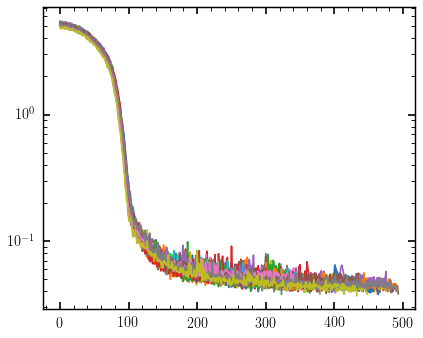

In [26]:
[plt.plot(NDE.vali_loss_history) for NDE in NDE_list]
plt.yscale('log')

In [27]:
torch.cuda.empty_cache()

### Show each NDE

In [28]:
from popsed.nde import transform_nmf_params, inverse_transform_nmf_params

In [29]:
_samples_unt = []
_samples = []
for NDE in [NDE_list[i] for i in np.argsort(vali_loss)[:]]:
    _samp = inverse_transform_nmf_params(NDE.sample(1000), _prior_NDE).cpu().detach().numpy()
    _z = np.random.choice(NDE.external_redshift_data, len(_samp))[:, None]
    _samp = np.hstack([_samp[:, :-1], _z, _samp[:, -1:]])
    
    _samples_unt.append(_samp)
    _samples.append(np.hstack([_samp[:, -1:], 
                   prior.FlatDirichletPrior(4).transform(_samp[:, :3]), 
                   _samp[:, 3:-1]]))
_samples_unt = np.dstack(_samples_unt)
_samples = np.dstack(_samples)

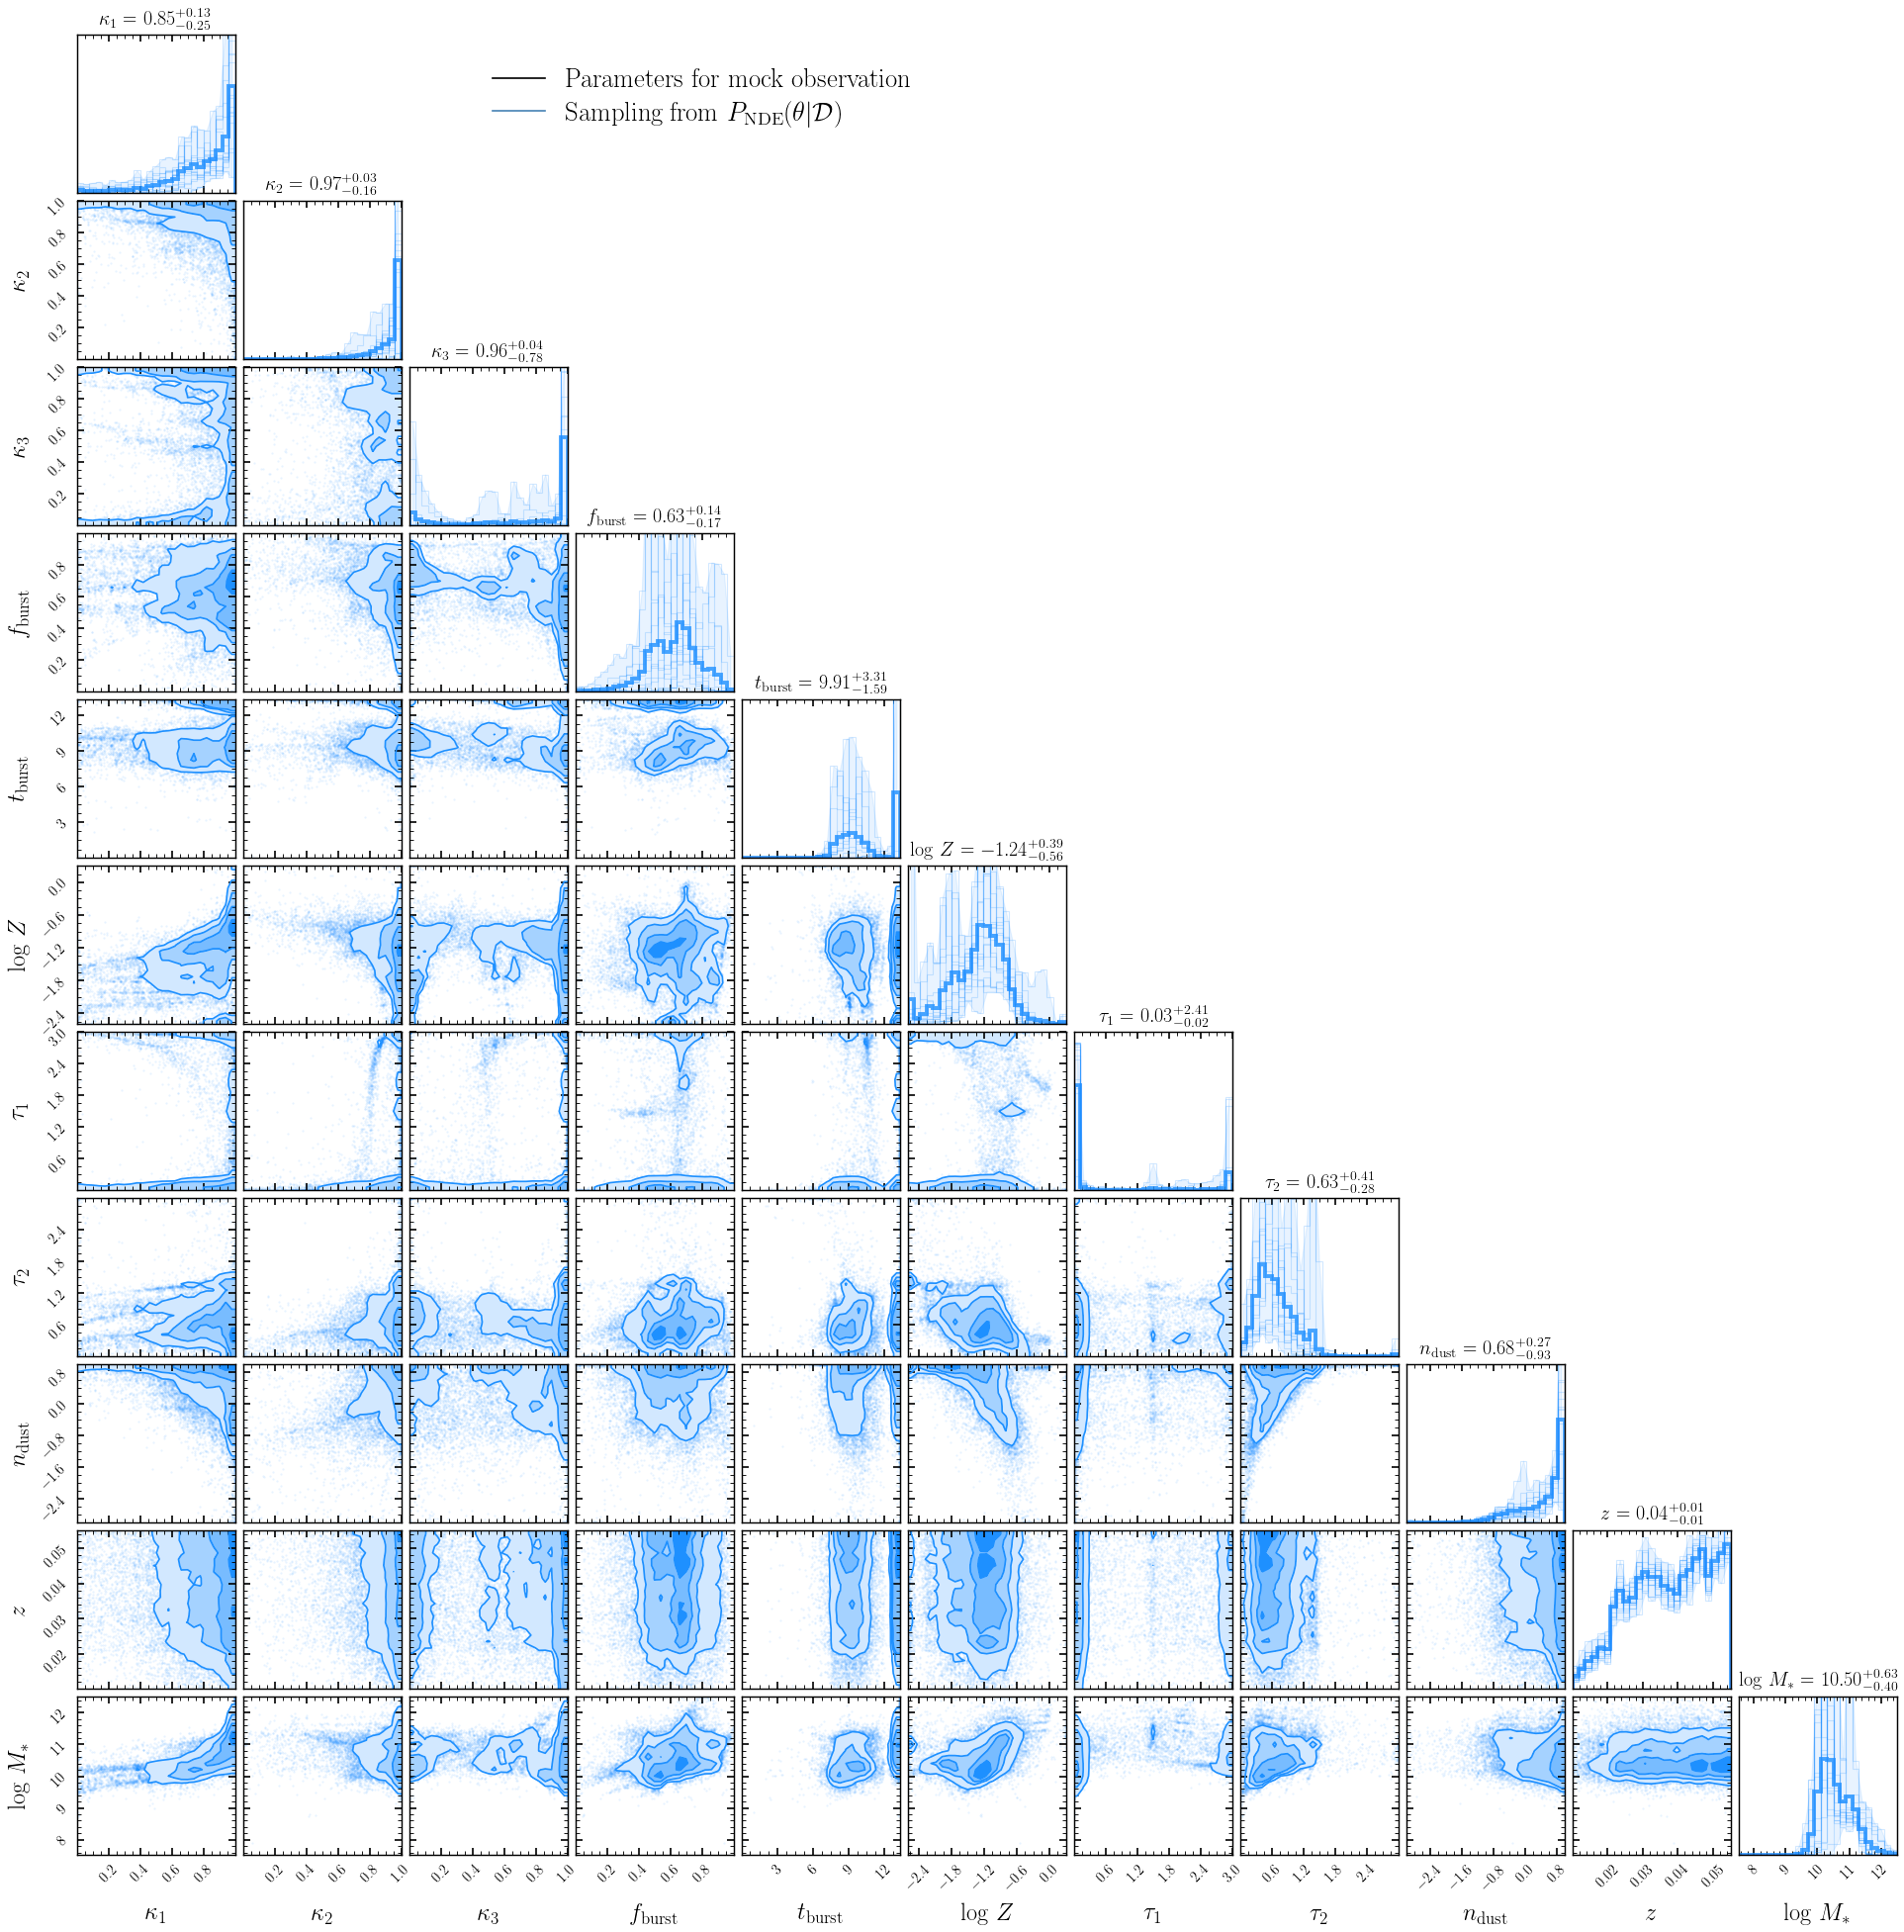

In [16]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Parameters for mock observation')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Sampling from $P_{\mathrm{NDE}}(\theta|\mathcal{D})$')

labels = [
    r'$\kappa_{1}$',
    r'$\kappa_{2}$',
    r'$\kappa_{3}$',
    r'$f_{\mathrm{burst}}$',
    r'$t_{\mathrm{burst}}$',
    r'$\log\,Z$',
    r'$\tau_1$',
    r'$\tau_2$',
    r'$n_{\mathrm{dust}}$',
    r'$z$',
    r'$\log\,M_*$',
    ]
# labels = [key.replace('_', '\_') for key in speculator.params_name]

# figure = corner.corner(
#     Y_truth.cpu().detach().numpy(),
#     color='dimgray',
#     labels=labels,
#     bins=25,
#     smooth=.5,
#     fill_contours=True,
#     show_titles=True,
#     title_kwargs={'fontsize': 18},
#     label_kwargs={'fontsize': 22},
#     hist_kwargs={'density': True},
#     plot_datapoints=False
#     )

nf_plot = corner.corner(
    _samples_unt,
#     fig=figure,
    labels=labels,
    color='dodgerblue',
    bins=25,
    smooth=.5,
    fill_contours=True,
    show_titles=True,
    title_kwargs={'fontsize': 18},
    label_kwargs={'fontsize': 22},
    hist_kwargs={'density': True, 'lw': 1},
    plot_datapoints=True
    )

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], 
          fontsize=24, 
          bbox_to_anchor=(0., 1.0, 1.3, .0))

In [30]:
# load nsa_sedflow
sedflow_sample = np.load('./nsa_sedflow/nsa_sedflow.posterior.reorganized.npy')

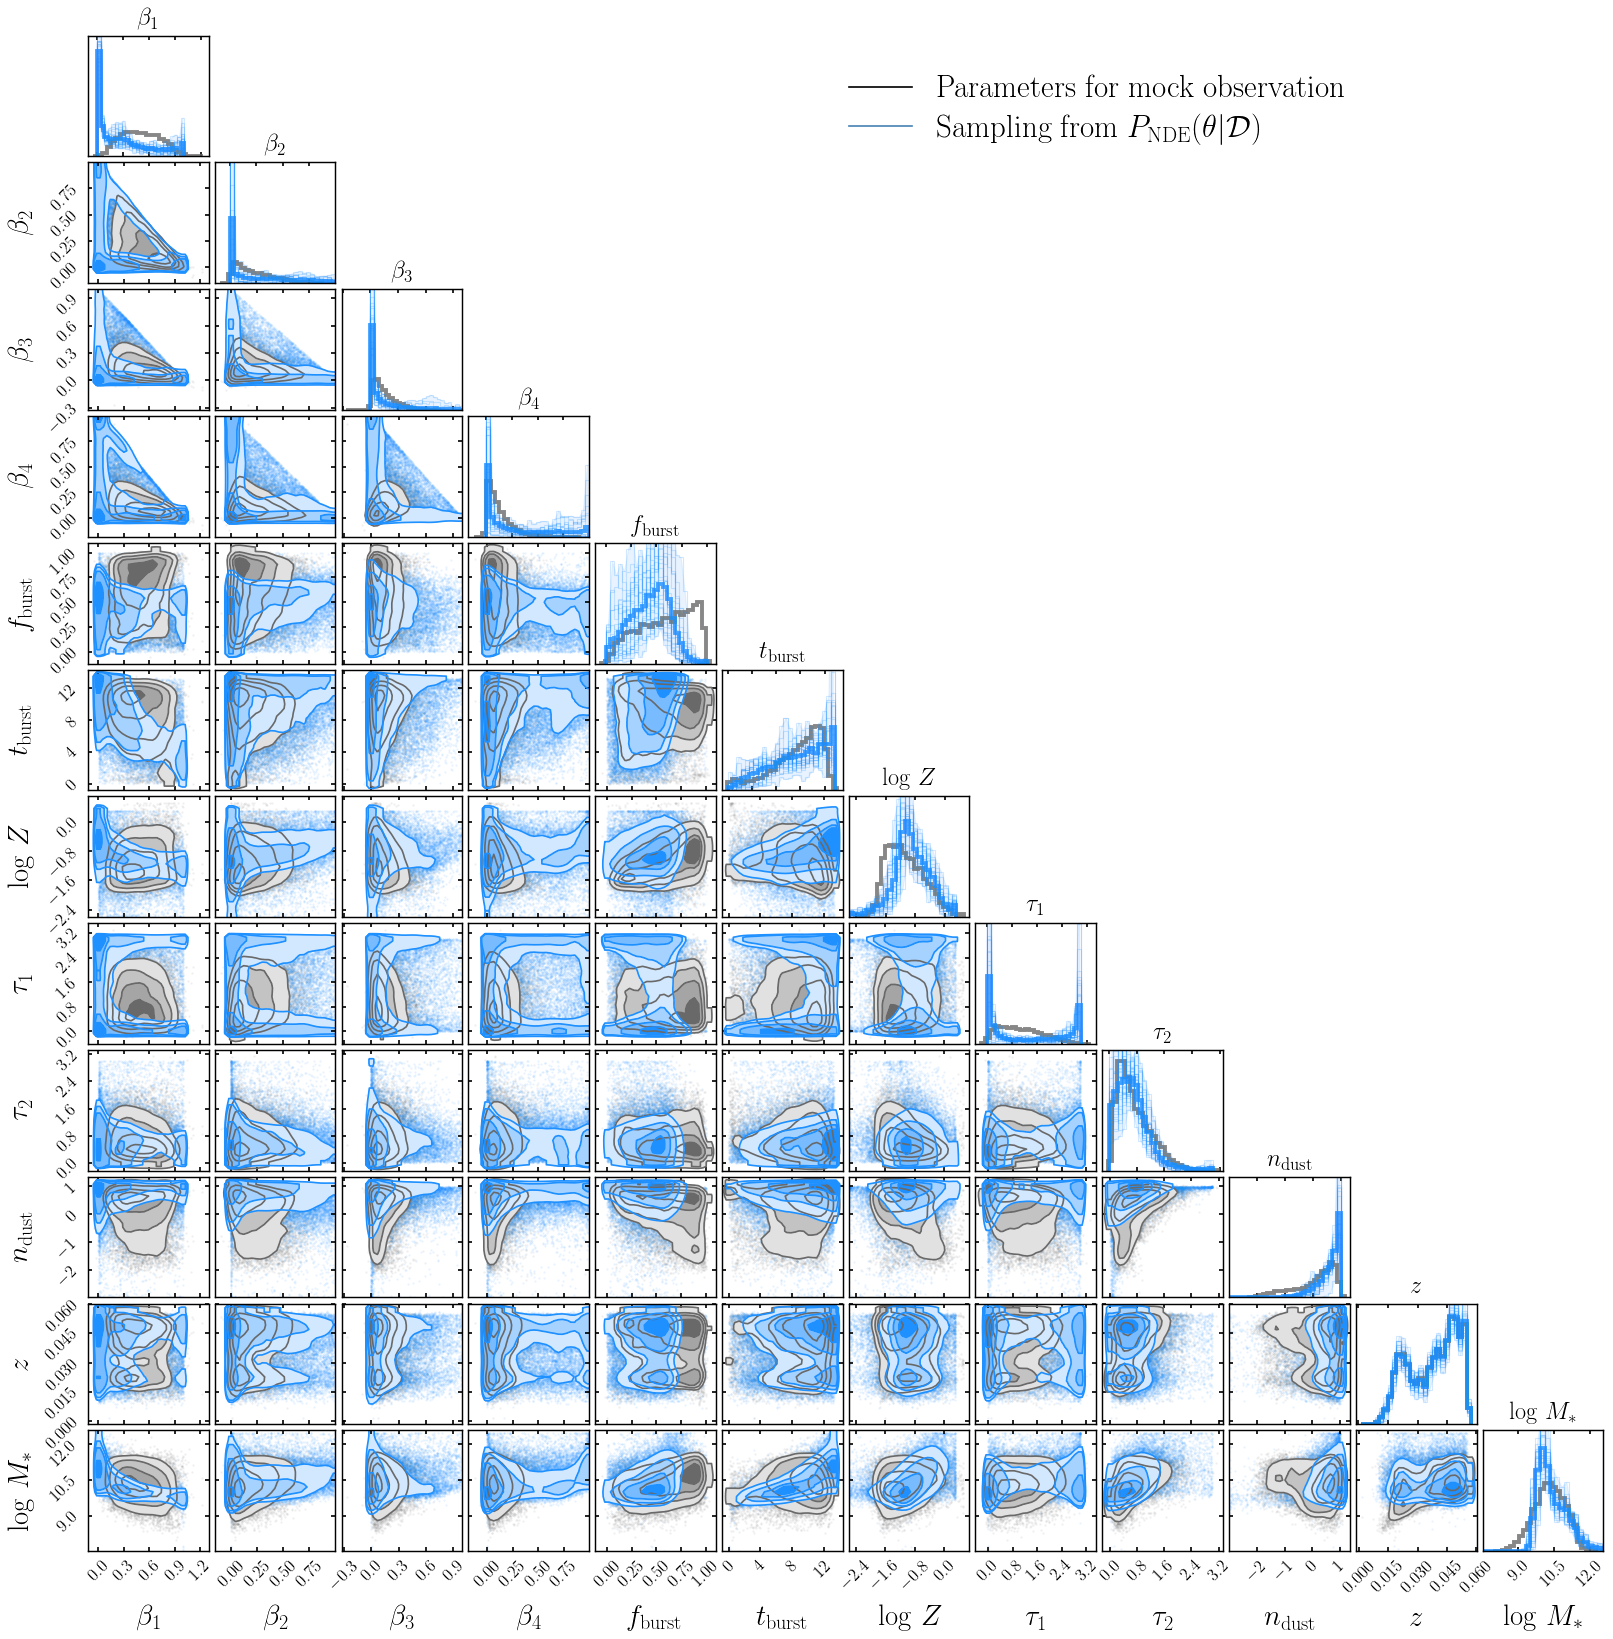

In [34]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Parameters for mock observation')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Sampling from $P_{\mathrm{NDE}}(\theta|\mathcal{D})$')

labels = [
    r'$\beta_{1}$',
    r'$\beta_{2}$',
    r'$\beta_{3}$',
    r'$\beta_{4}$',
    r'$f_{\mathrm{burst}}$',
    r'$t_{\mathrm{burst}}$',
    r'$\log\,Z$',
    r'$\tau_1$',
    r'$\tau_2$',
    r'$n_{\mathrm{dust}}$',
    r'$z$',
    r'$\log\,M_*$',
    ]

figure, axes = plt.subplots(12, 12, figsize=(20, 20))
figure = corner.corner(
    sedflow_sample,
    fig=figure,
    color='dimgray',
    labels=labels,
    bins=25,
    smooth=1.0,
    fill_contours=True,
    show_titles=True,
    title_fmt=None,
    title_kwargs={'fontsize': 22},
    label_kwargs={'fontsize': 26},
    labelpad=0.15,
    hist_kwargs={'density': True},
    plot_datapoints=True
    )

y_truth_trans = np.hstack([_samples[:, 1:], # params taken by emulator, including redshift (for t_age)
                           _samples[:, 0:1], # stellar mass
                    ])

figure = corner.corner(
    y_truth_trans,
    fig=figure,
    color='dodgerblue',
    labels=labels,
#     range=[[0, 1], [0, 1], [0., 1], [0, 1], [-0.02, 1.02], [0.5, 13], 
#            [-2.5, 0.3], [0, 3], [0, 1.6], [-2, 1], [0, 0.06], [8, 12]],
    bins=25,
    smooth=1.0,
    fill_contours=True,
    show_titles=False,
    title_kwargs={'fontsize': 18},
    label_kwargs={'fontsize': 26},
    labelpad=0.15,
    hist_kwargs={'density': True, 'lw': 1},
#     plot_datapoints=False
    )

for ax in figure.get_axes():
    ax.tick_params(labelsize=15, length=4)
    ax.minorticks_off()

ax = figure.get_axes()[9]
ax.legend(handles=[k_line, b_line], 
          fontsize=28, 
          bbox_to_anchor=(0., 1.0, 1.3, .0))

# plt.savefig('/home/jiaxuanl/Research/popsed/figure/.png', dpi=100, bbox_inches='tight') # slow

In [23]:
# del _samples
# import gc
# gc.collect()

0 5000
>30 0


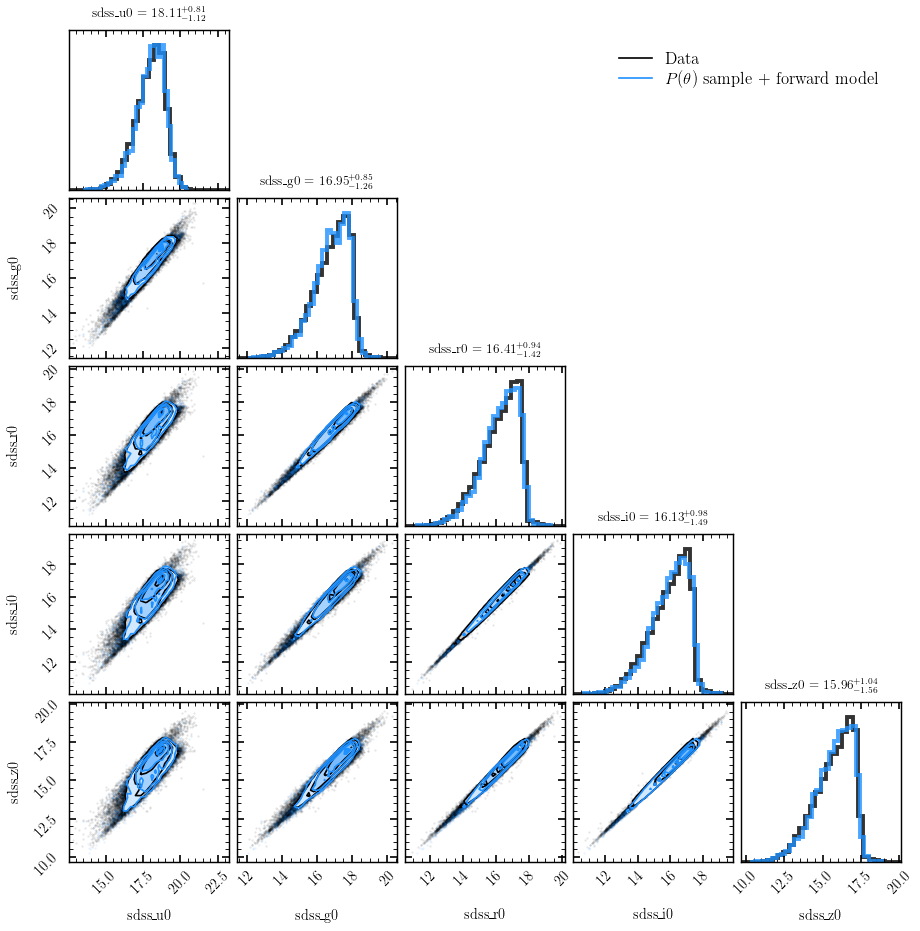

In [18]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = [filt.replace('_', '\_') for filt in filters]

figure = corner.corner(X_data.cpu().detach().numpy(), 
                       color='k', labels=labels, bins=30,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.4, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

_spl = _samples_unt.swapaxes(0, 1).reshape(11, -1).T
_spl = torch.Tensor(_spl[np.random.randint(0, len(_spl), 5000)]).to('cuda')
# _z = torch.Tensor(np.random.choice(NDE.external_redshift_data, len(_spl))[
#     :, None]).to(NDE.device)
# _spl = torch.hstack([_spl[:, :-1], _z, _spl[:, -1:]])

mags = speculator._predict_mag_with_mass_redshift(_spl,
                                                  filterset=filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>30', np.any(mags > 30, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 30, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=30,
                        #range=[[14, 25]] * 5,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [19]:
sedflow_sample_unt = np.hstack([prior.FlatDirichletPrior(4).untransform(sedflow_sample[:, :4]), 
                                sedflow_sample[:, 4:]])

In [20]:
sedflow_sample_unt.shape

(10000, 11)

In [21]:
# sedflow_mag = np.load('./nsa_sedflow/nsa_sedflow.posterior_combined.nanomaggies.npy')
# mags = -2.5 * np.log10(sedflow_mag) + 22.5

0 5000
>30 0
0 5000
>30 0
38 9959
>30 0


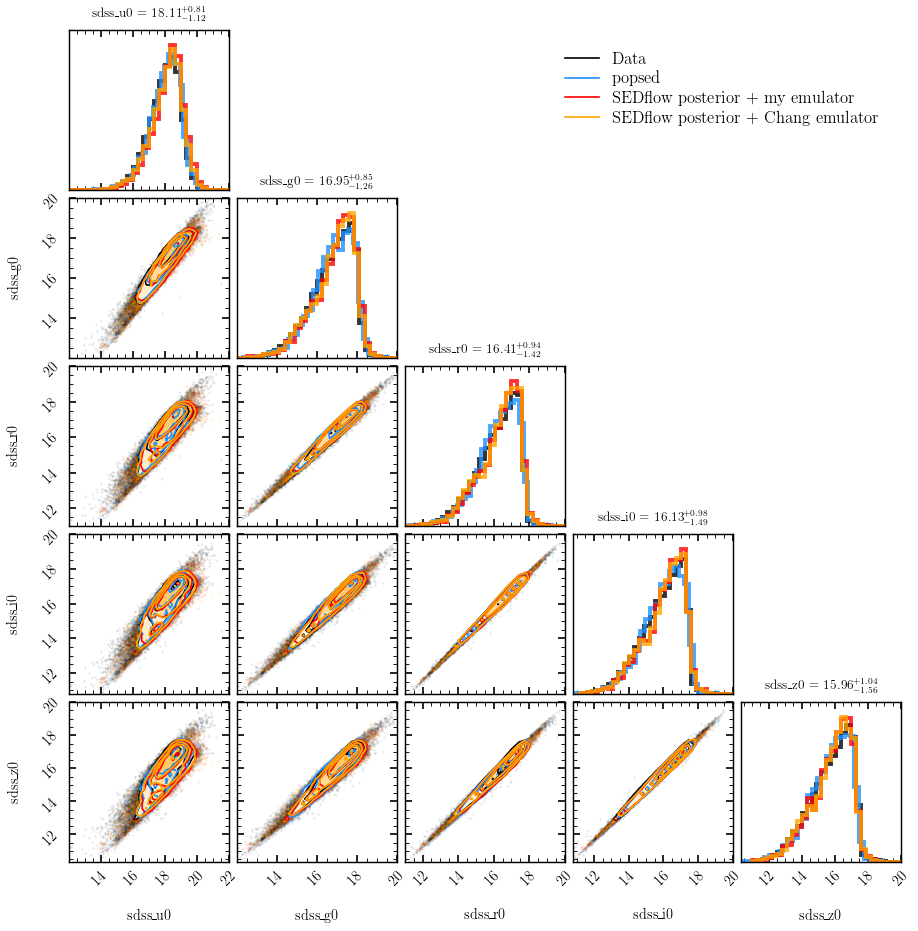

In [22]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
r_line = mlines.Line2D([], [], color='r', label='SEDflow posterior + my emulator')
o_line = mlines.Line2D([], [], color='orange', label='SEDflow posterior + Chang emulator')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'popsed')

labels = [filt.replace('_', '\_') for filt in filters]

figure = corner.corner(X_data.cpu().detach().numpy(), 
                       color='k', labels=labels, bins=30,
                       range=[[12, 22], [12, 20], [11, 20], [11, 20], [11, 20]],
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.4, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

mags = speculator._predict_mag_with_mass_redshift(_spl,
                                                  filterset=filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>30', np.any(mags > 30, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 30, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=30,
                        #range=[[14, 25]] * 5,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})


_spl = sedflow_sample_unt
_spl = torch.Tensor(_spl[np.random.randint(0, len(_spl), 5000)]).to('cuda')
mags = speculator._predict_mag_with_mass_redshift(_spl,
                                                  filterset=filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>30', np.any(mags > 30, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 30, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=30,
                  range=[[12, 22], [12, 20], [11, 20], [11, 20], [11, 20]],
                  color='red', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})


sedflow_mag = np.load('./nsa_sedflow/nsa_sedflow.posterior_combined.nanomaggies.npy')
mags = -2.5 * np.log10(sedflow_mag) + 22.5
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>30', np.any(mags > 30, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 30, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=30,
                  range=[[12, 22], [12, 20], [11, 20], [11, 20], [11, 20]],
                  color='orange', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})


ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line, r_line, o_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [23]:
from geomloss import SamplesLoss
L = SamplesLoss(loss='sinkhorn', **{'p': 1, 'blur': 0.1, 'scaling': 0.5})
intr_loss = L(X_data[:3000], torch.Tensor(mags[:3000])).item()
print("Intrinsic sampling loss:", intr_loss)

Intrinsic sampling loss: 0.08481302857398987


In [24]:
_spl = sedflow_sample_unt
_spl = torch.Tensor(_spl[np.random.randint(0, len(_spl), 5000)]).to('cuda')
mags = speculator._predict_mag_with_mass_redshift(_spl,
                                                  filterset=filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()

In [25]:
from geomloss import SamplesLoss
# L = SamplesLoss(loss='sinkhorn', **{'p': 1, 'blur': 1e-2, 'scaling': 0.7})
intr_loss = L(X_data[:3000], torch.Tensor(mags[:3000])).item()
print("Intrinsic sampling loss:", intr_loss)

Intrinsic sampling loss: 0.09192287921905518


In [26]:
_spl = _samples_unt.swapaxes(0, 1).reshape(11, -1).T
_spl = torch.Tensor(_spl[np.random.randint(0, len(_spl), 5000)]).to('cuda')
mags = speculator._predict_mag_with_mass_redshift(_spl,
                                                  filterset=filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()

In [27]:
from geomloss import SamplesLoss
# L = SamplesLoss(loss='sinkhorn', **{'p': 1, 'blur': 1e-2, 'scaling': 0.7})
intr_loss = L(X_data[:3000], torch.Tensor(mags[:3000])).item()
print("Intrinsic sampling loss:", intr_loss)

Intrinsic sampling loss: 0.05697385221719742


In [34]:
torch.cuda.empty_cache()

In [35]:
# sample the initial setups
_init_sample = []

for NDE in [NDE_list[i] for i in np.argsort(vali_loss)]:
    _mean = NDE.mean_init
    _stds = NDE.initial_pos['std']
    _init_sample.append(np.random.normal(_mean, _stds, size=(1000, 11)))
    
_init_sample = np.array(_init_sample).reshape(-1, 11)

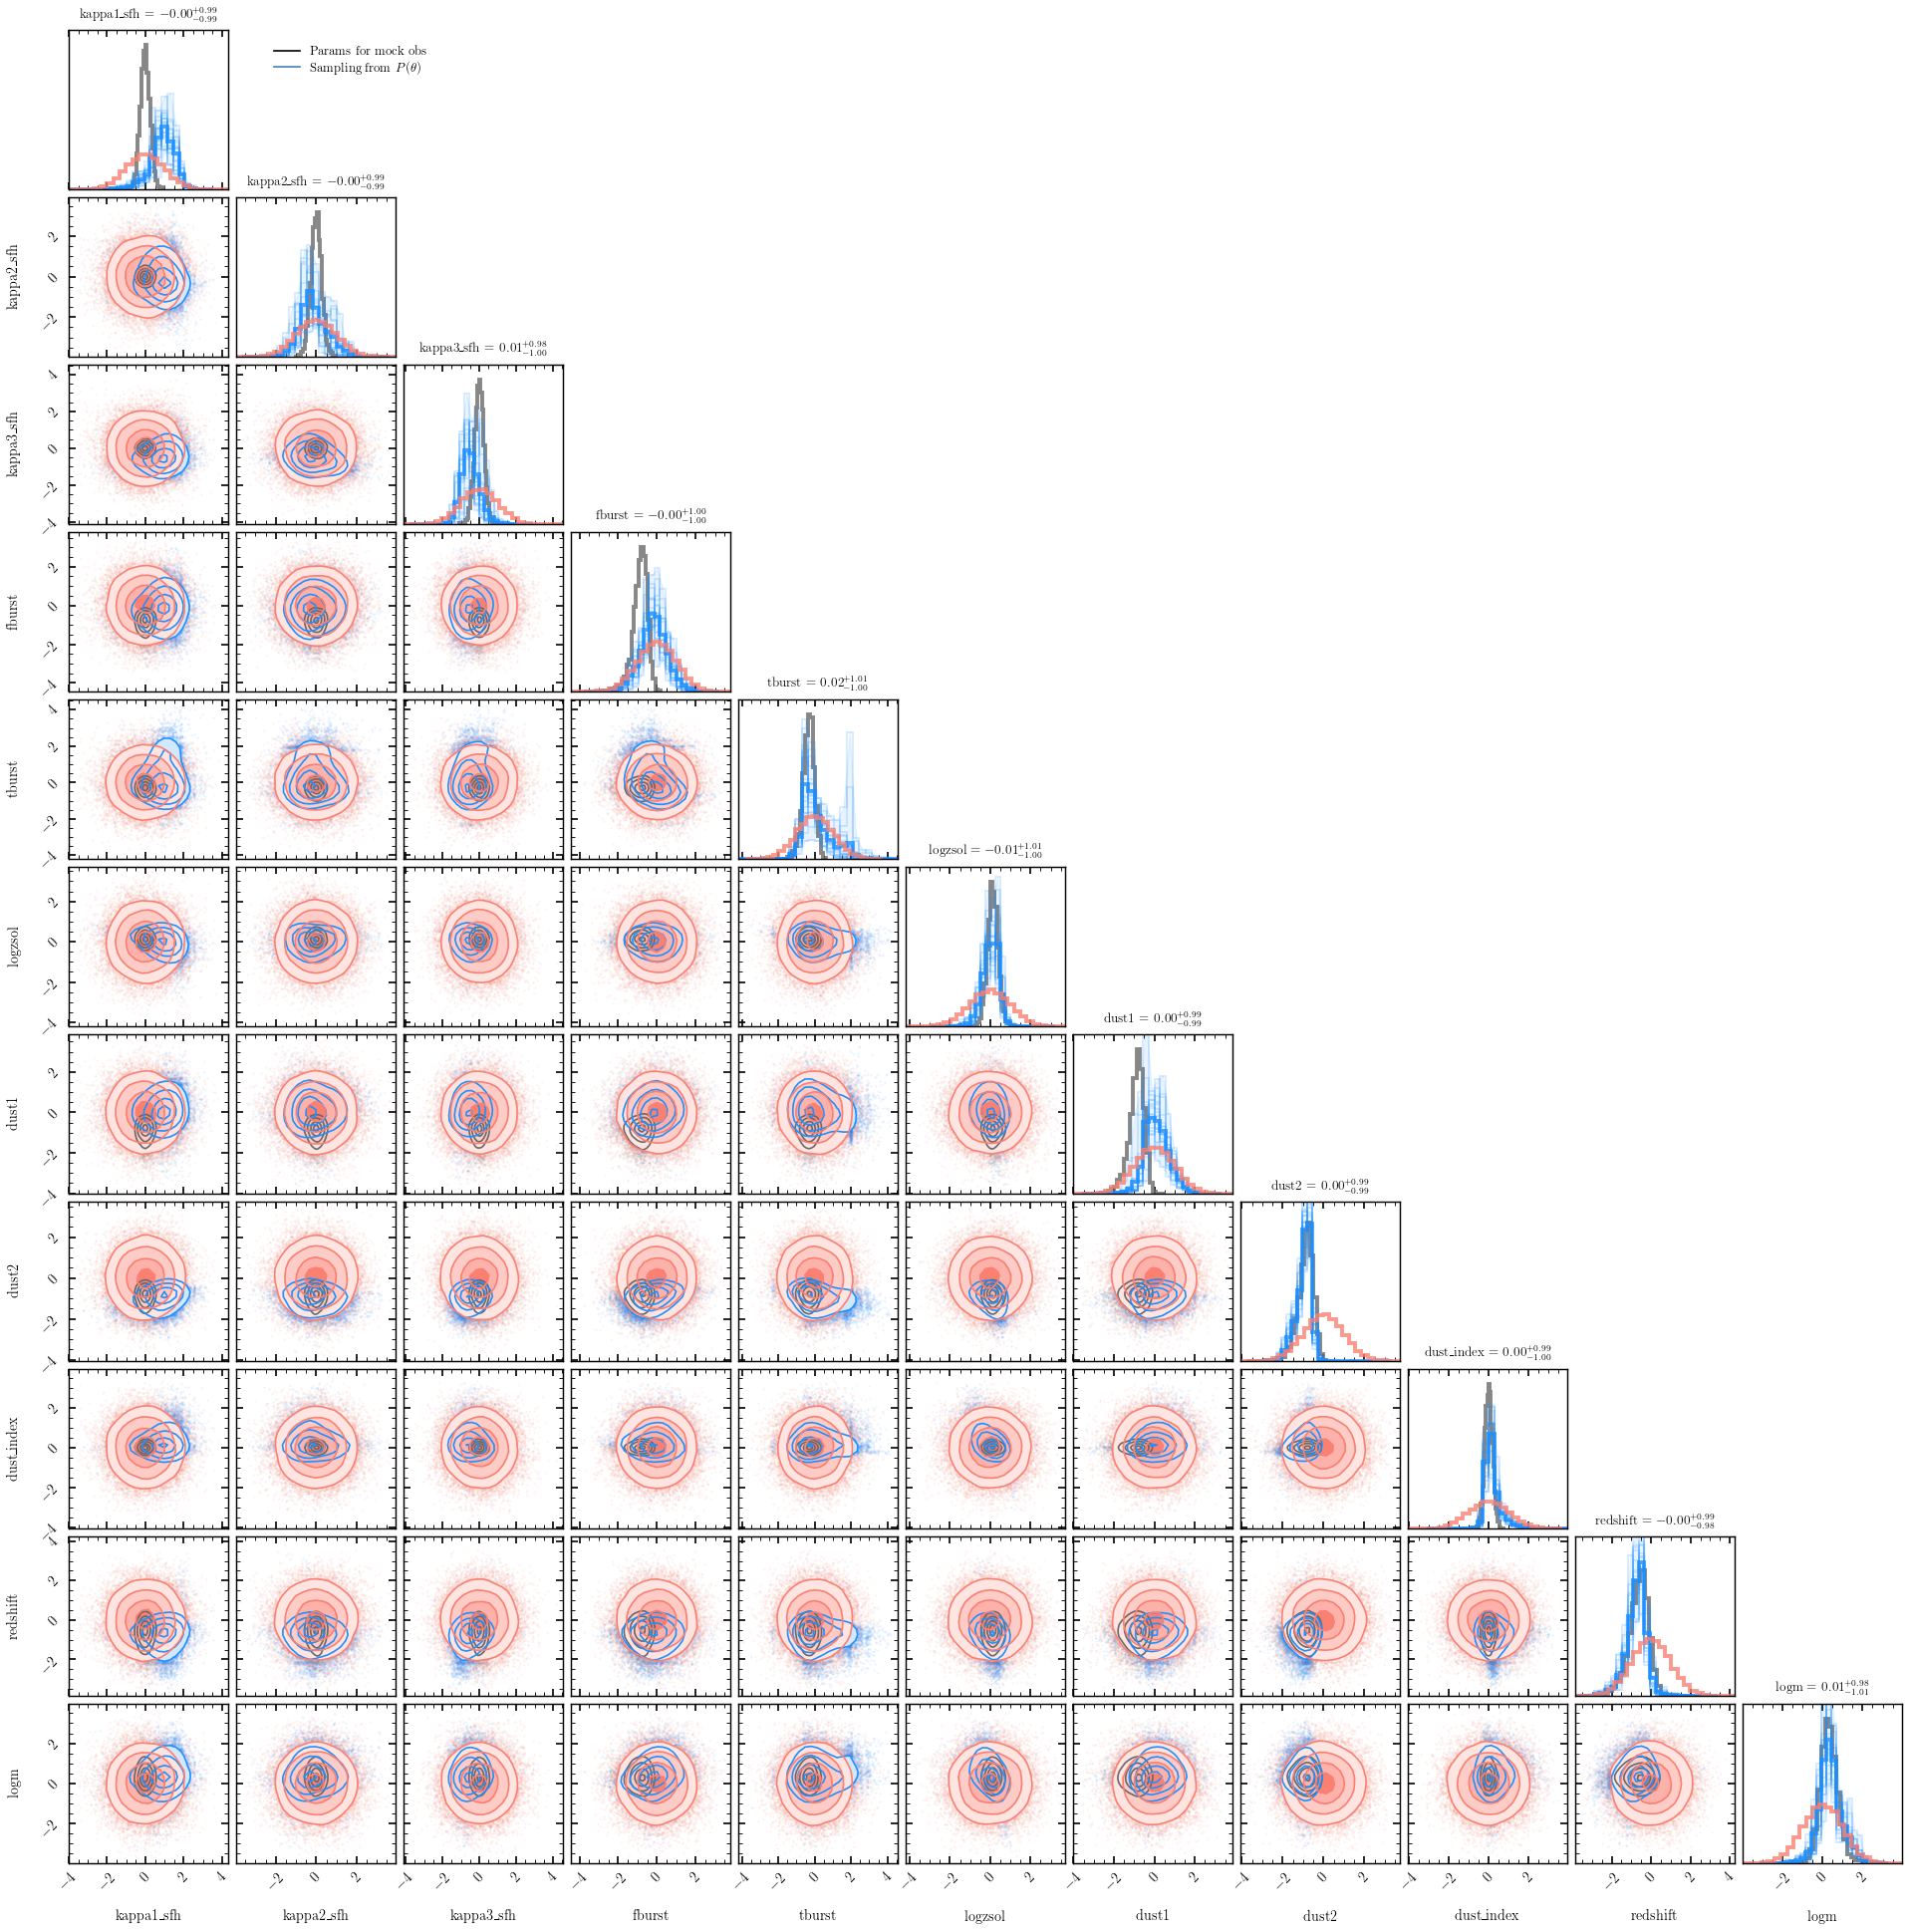

In [36]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Sampling from $P(\theta)$')

labels = [key.replace('_', '\_') for key in speculator.params_name]

figure = corner.corner(transform_nmf_params(Y_truth, _prior_NDE).cpu().detach().numpy(), 
                       color='dimgray', labels=labels, bins=25,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=1, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

nf_plot = corner.corner(transform_nmf_params(torch.Tensor(_samples_unt).to('cuda'), _prior_NDE
                                            ).cpu().detach().numpy(), 
                  fig=figure, labels=labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=1, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

_ = corner.corner(_init_sample, 
                   fig=figure, color='salmon', alpha=0.1, labels=labels, bins=25,
                   #quantiles=[0.16, 0.5, 0.84], 
                   smooth=0.8, fill_contours=True,
                   show_titles=True, 
                   hist_kwargs={'density': True, 'lw': 0.5}, 
                   title_kwargs={"fontsize": 12},
                   plot_datapoints=True)

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))